Dataset Shape: (40160, 14)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40160 entries, 0 to 40159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Report Number       40160 non-null  int64 
 1   Date Reported       40160 non-null  object
 2   Date of Occurrence  40160 non-null  object
 3   Time of Occurrence  40160 non-null  object
 4   City                40160 non-null  object
 5   Crime Code          40160 non-null  int64 
 6   Crime Description   40160 non-null  object
 7   Victim Age          40160 non-null  int64 
 8   Victim Gender       40160 non-null  object
 9   Weapon Used         34370 non-null  object
 10  Crime Domain        40160 non-null  object
 11  Police Deployed     40160 non-null  int64 
 12  Case Closed         40160 non-null  object
 13  Date Case Closed    20062 non-null  object
dtypes: int64(4), object(10)
memory usage: 4.3+ MB
None

First few rows:
   Repor

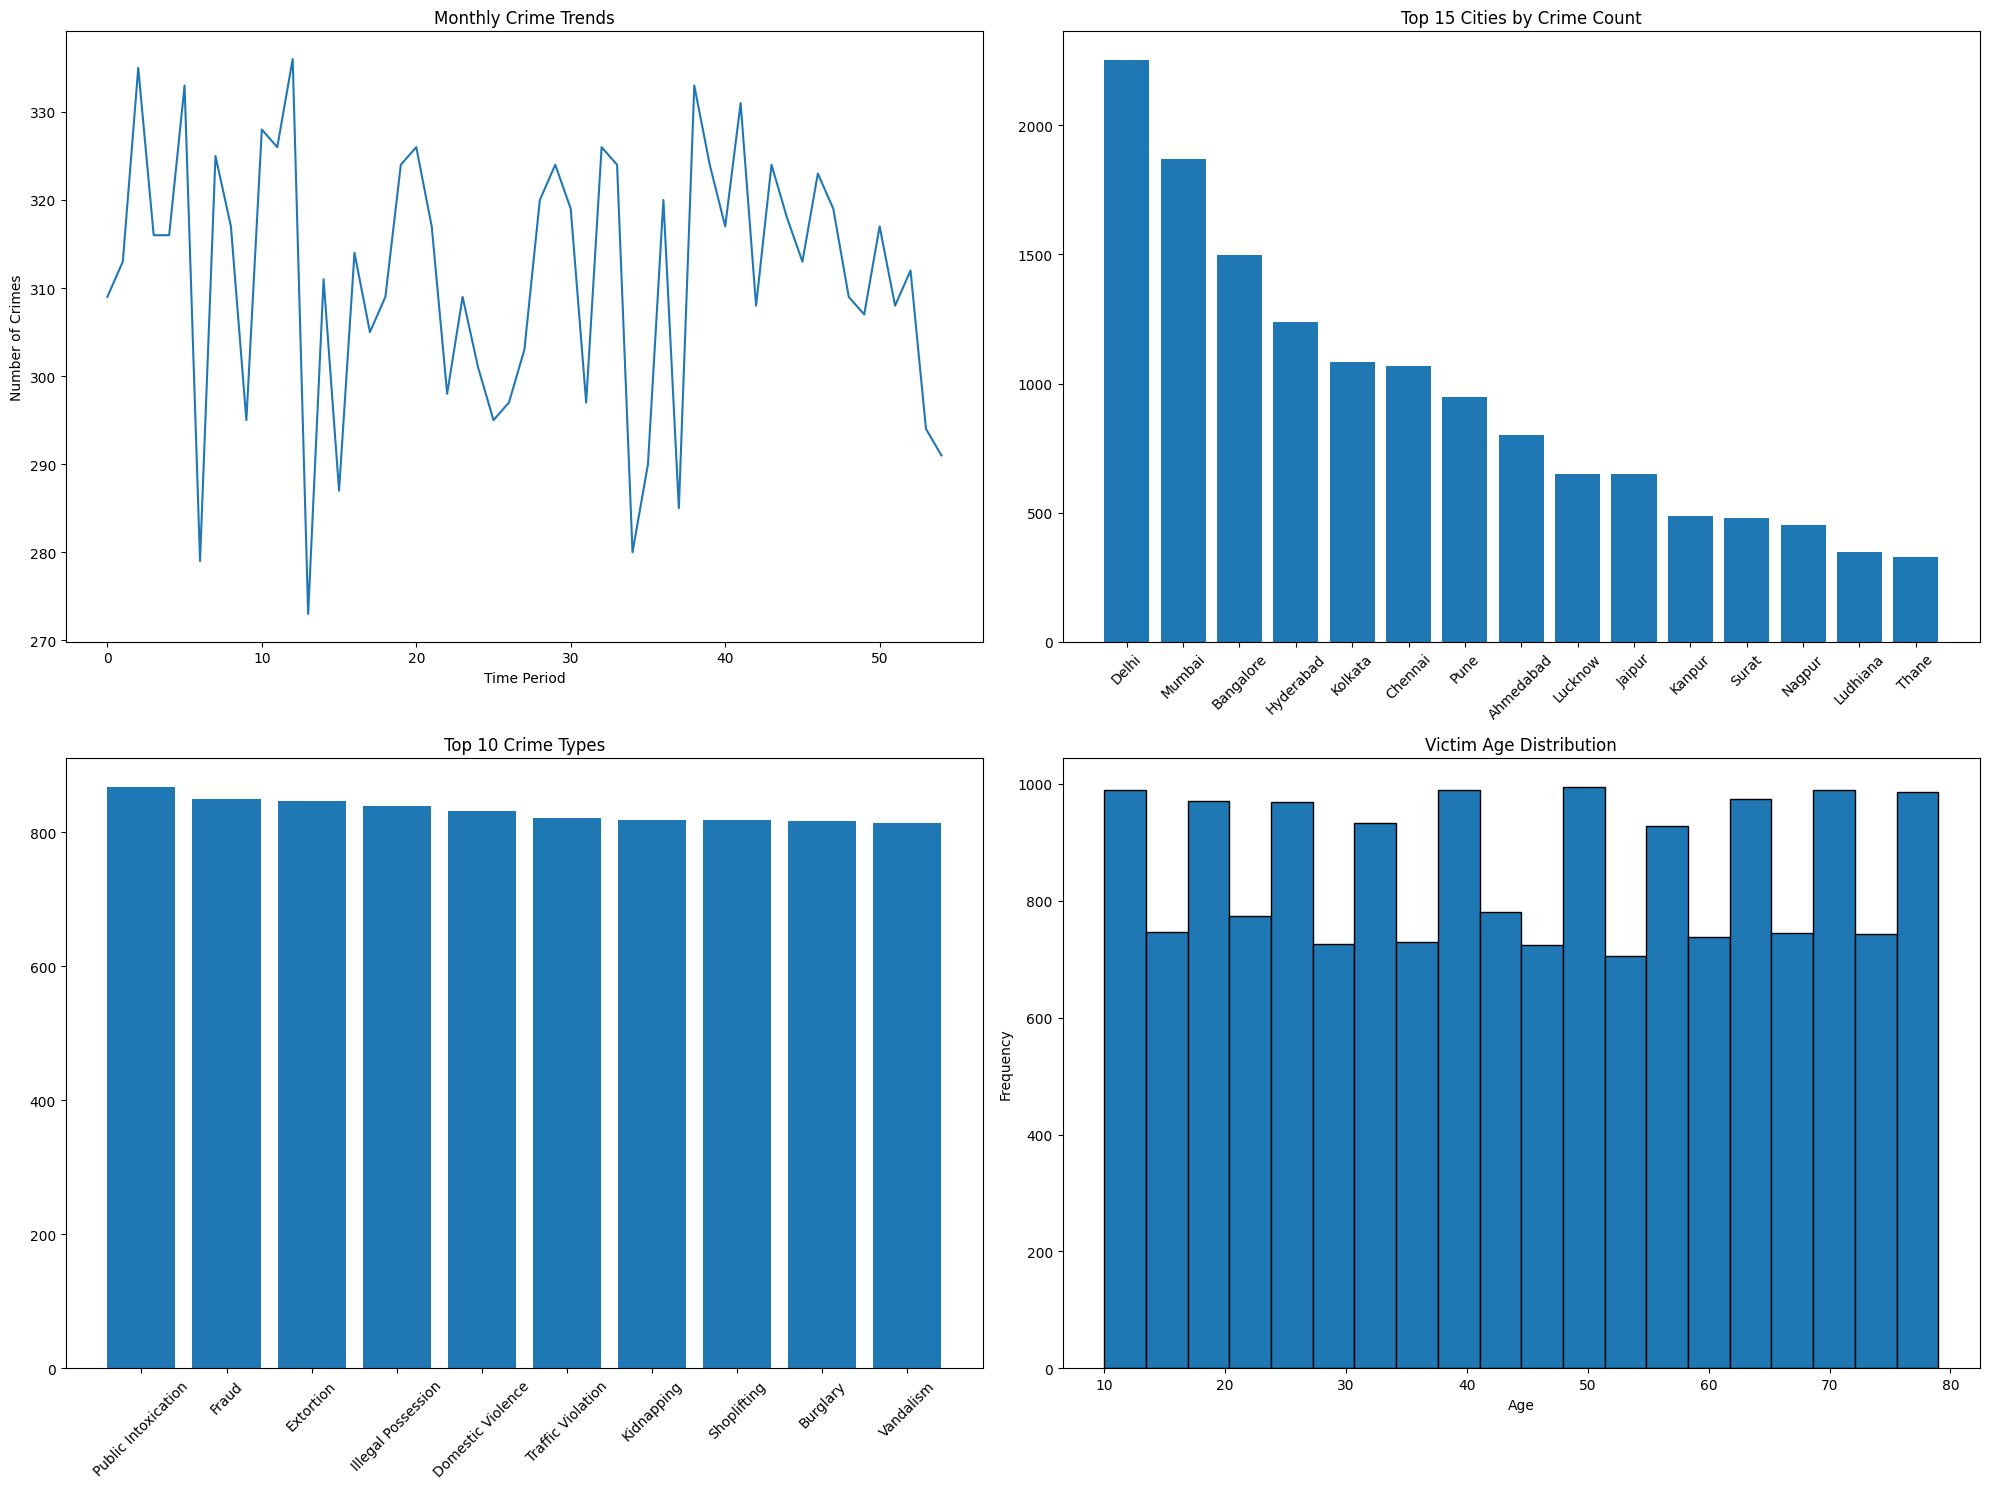

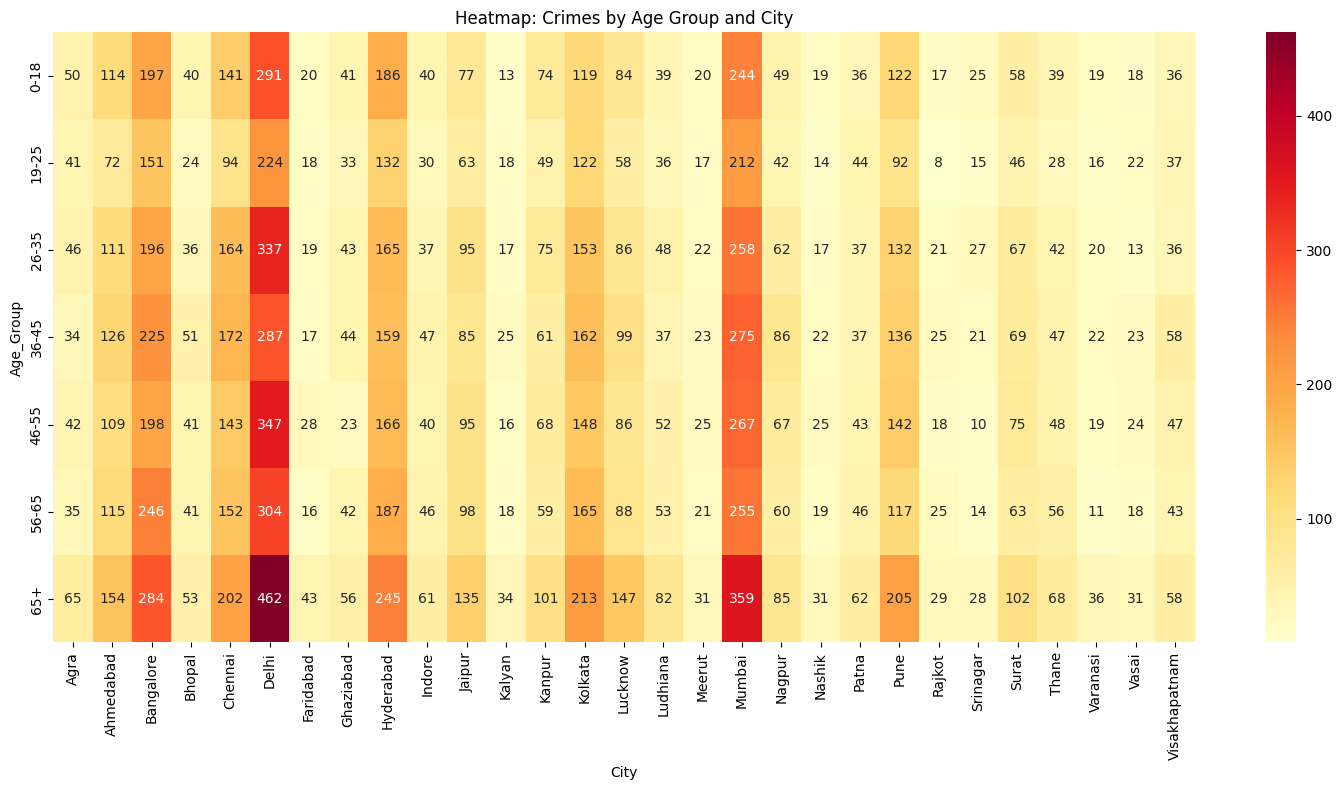

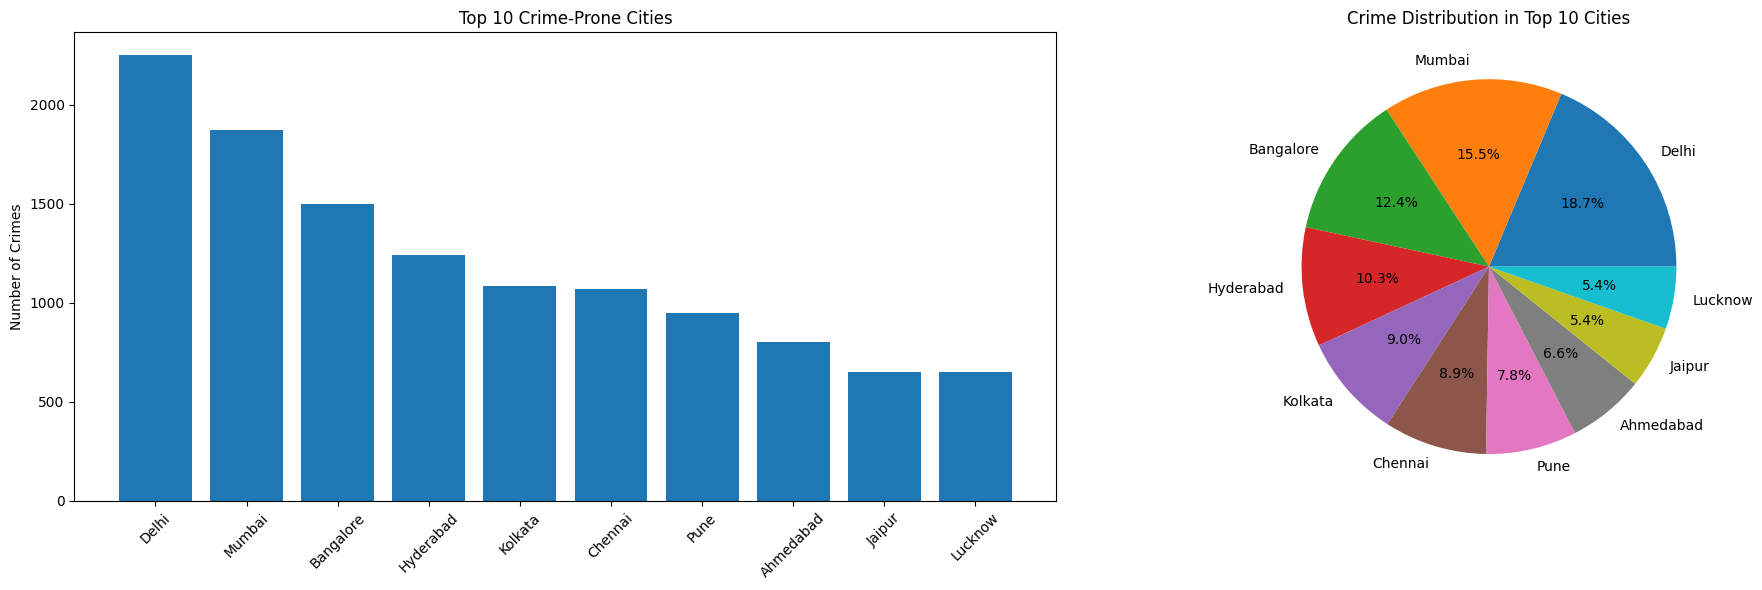

Feature Importance for Crime Prediction:
         feature  importance
1     Victim Age    0.471495
0           City    0.383908
2  Victim Gender    0.144597
Top 10 Safest Cities:
           Safety_Score  Safety_Rank
City                                
Srinagar      93.783304          1.0
Kalyan        93.738899          2.0
Rajkot        93.650089          3.5
Varanasi      93.650089          3.5
Nashik        93.472469          5.0
Vasai         93.383659          6.0
Meerut        92.939609          7.0
Faridabad     92.850799          8.0
Ghaziabad     87.477798          9.0
Bhopal        87.300178         10.0

Top 10 Most Dangerous Cities:
           Safety_Score  Safety_Rank
City                                
Delhi          0.000000         29.0
Mumbai        16.962700         28.0
Bangalore     33.525755         27.0
Hyderabad     44.937833         26.0
Kolkata       51.953819         25.0
Chennai       52.575488         24.0
Pune          57.992895         23.0
Ahmedabad    

=== CRIME DATA SUMMARY INSIGHTS ===
Total Records Analyzed: 17,130
Time Period: 2020-01-01 03:00:00 to 2024-07-31 07:00:00
Number of Cities: 29
Number of Crime Types: 21
Average Victim Age: 44.5 years
Most Common Victim Age Group: (37.6, 51.4]
Gender Distribution: {'F': 56.05370694687682, 'M': 33.0881494454174, 'X': 10.85814360770578}
Most Common Crime: Public Intoxication

=== ANALYSIS COMPLETE ===
Generated Files:
1. cleaned_crime_data_india.csv - Cleaned dataset
2. city_safety_scores.csv - Safety scores for all cities
3. crime_analysis_summary.txt - Summary report


In [1]:
# Step 1: Install required packages
!pip install pandas numpy matplotlib seaborn plotly folium scikit-learn

# Step 2: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report
import warnings
warnings.filterwarnings('ignore')

# Step 3: Load and explore the dataset
def load_crime_data():
    # Load the dataset
    df = pd.read_csv('crime_dataset_india.csv')

    print("Dataset Shape:", df.shape)
    print("\nDataset Info:")
    print(df.info())
    print("\nFirst few rows:")
    print(df.head())
    print("\nMissing values:")
    print(df.isnull().sum())

    return df

# Load the data
df = load_crime_data()

# Step 4: Data Preprocessing and Cleaning
def preprocess_data(df):
    # Create a copy of the dataset
    df_clean = df.copy()

    # Handle missing values
    df_clean = df_clean.dropna()

    # Remove duplicates
    df_clean = df_clean.drop_duplicates()

    # Convert date columns to datetime
    date_columns = ['Date Reported', 'Date of Occurrence']
    for col in date_columns:
        if col in df_clean.columns:
            df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')

    # Clean categorical columns
    categorical_columns = ['City', 'Crime Description', 'Victim Gender', 'Weapon Used', 'Crime Domain']
    for col in categorical_columns:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].astype(str).str.strip().str.title()

    # Clean numerical columns
    if 'Victim Age' in df_clean.columns:
        df_clean['Victim Age'] = pd.to_numeric(df_clean['Victim Age'], errors='coerce')
        df_clean = df_clean[df_clean['Victim Age'].between(0, 100)]

    print(f"Data after preprocessing: {df_clean.shape}")
    return df_clean

df_clean = preprocess_data(df)

# Step 5: Exploratory Data Analysis (EDA)

# 5.1 Crime Trends Over Time
def plot_crime_trends(df):
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))

    # Monthly crime trends
    if 'Date of Occurrence' in df.columns:
        df['Year'] = df['Date of Occurrence'].dt.year
        df['Month'] = df['Date of Occurrence'].dt.month

        monthly_crimes = df.groupby(['Year', 'Month']).size().reset_index(name='Count')
        axes[0,0].plot(monthly_crimes.index, monthly_crimes['Count'])
        axes[0,0].set_title('Monthly Crime Trends')
        axes[0,0].set_xlabel('Time Period')
        axes[0,0].set_ylabel('Number of Crimes')

    # Crime by city (top 15)
    if 'City' in df.columns:
        city_crimes = df['City'].value_counts().head(15)
        axes[0,1].bar(city_crimes.index, city_crimes.values)
        axes[0,1].set_title('Top 15 Cities by Crime Count')
        axes[0,1].tick_params(axis='x', rotation=45)

    # Crime types distribution
    if 'Crime Description' in df.columns:
        crime_types = df['Crime Description'].value_counts().head(10)
        axes[1,0].bar(crime_types.index, crime_types.values)
        axes[1,0].set_title('Top 10 Crime Types')
        axes[1,0].tick_params(axis='x', rotation=45)

    # Victim age distribution
    if 'Victim Age' in df.columns:
        axes[1,1].hist(df['Victim Age'].dropna(), bins=20, edgecolor='black')
        axes[1,1].set_title('Victim Age Distribution')
        axes[1,1].set_xlabel('Age')
        axes[1,1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

plot_crime_trends(df_clean)

# 5.2 Interactive Crime Analysis by Age and City
def interactive_age_city_analysis(df):
    if 'Victim Age' in df.columns and 'City' in df.columns:
        # Create age groups
        df['Age_Group'] = pd.cut(df['Victim Age'],
                                bins=[0, 18, 25, 35, 45, 55, 65, 100],
                                labels=['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '65+'])

        # Crime distribution by age group and city
        age_city_crime = df.groupby(['Age_Group', 'City']).size().reset_index(name='Count')

        # Interactive bar chart
        fig = px.bar(age_city_crime, x='Age_Group', y='Count', color='City',
                    title='Crime Distribution by Age Group and City',
                    labels={'Age_Group': 'Age Group', 'Count': 'Number of Crimes'})
        fig.show()

        # Heatmap of crimes by age group and city
        pivot_table = age_city_crime.pivot(index='Age_Group', columns='City', values='Count').fillna(0)
        plt.figure(figsize=(15, 8))
        sns.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt='.0f')
        plt.title('Heatmap: Crimes by Age Group and City')
        plt.tight_layout()
        plt.show()

interactive_age_city_analysis(df_clean)

# 5.3 Crime Hotspot Analysis
def crime_hotspot_analysis(df):
    if 'City' in df.columns:
        # Calculate crime rates per city
        city_crime_stats = df.groupby('City').agg({
            'Report Number': 'count',
            'Victim Age': 'mean'
        }).rename(columns={'Report Number': 'Total_Crimes', 'Victim Age': 'Average_Victim_Age'})

        # Top crime-prone cities
        top_crime_cities = city_crime_stats.nlargest(10, 'Total_Crimes')

        fig, axes = plt.subplots(1, 2, figsize=(20, 6))

        # Bar chart of top crime cities
        axes[0].bar(top_crime_cities.index, top_crime_cities['Total_Crimes'])
        axes[0].set_title('Top 10 Crime-Prone Cities')
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].set_ylabel('Number of Crimes')

        # Pie chart of crime distribution
        axes[1].pie(top_crime_cities['Total_Crimes'], labels=top_crime_cities.index, autopct='%1.1f%%')
        axes[1].set_title('Crime Distribution in Top 10 Cities')

        plt.tight_layout()
        plt.show()

        return city_crime_stats

city_stats = crime_hotspot_analysis(df_clean)

# Step 6: Statistical Analysis and ML Models

# 6.1 Crime Prediction Model
def build_crime_prediction_model(df):
    # Prepare data for modeling
    df_model = df.copy()

    # Encode categorical variables
    label_encoders = {}
    categorical_cols = ['City', 'Crime Description', 'Victim Gender', 'Weapon Used']

    for col in categorical_cols:
        if col in df_model.columns:
            le = LabelEncoder()
            df_model[col] = le.fit_transform(df_model[col].astype(str))
            label_encoders[col] = le

    # Create features and target
    features = ['City', 'Victim Age', 'Victim Gender']
    target = 'Crime Description'

    if all(col in df_model.columns for col in features + [target]):
        X = df_model[features]
        y = df_model[target]

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Train Random Forest model
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)

        # Predictions
        y_pred = rf_model.predict(X_test)

        # Calculate feature importance
        feature_importance = pd.DataFrame({
            'feature': features,
            'importance': rf_model.feature_importances_
        }).sort_values('importance', ascending=False)

        print("Feature Importance for Crime Prediction:")
        print(feature_importance)

        return rf_model, label_encoders

    return None, None

crime_model, encoders = build_crime_prediction_model(df_clean)

# 6.2 City Safety Scoring System
def calculate_city_safety_scores(df):
    if 'City' in df.columns and 'Crime Description' in df.columns:
        # Calculate various safety metrics
        city_safety = df.groupby('City').agg({
            'Report Number': 'count',  # Total crimes
            'Victim Age': 'mean',      # Average victim age
        }).rename(columns={'Report Number': 'Total_Crimes', 'Victim Age': 'Avg_Victim_Age'})

        # Normalize scores (lower crimes = safer)
        city_safety['Crime_Score'] = 1 - (city_safety['Total_Crimes'] / city_safety['Total_Crimes'].max())
        city_safety['Safety_Score'] = city_safety['Crime_Score'] * 100

        # Rank cities by safety
        city_safety['Safety_Rank'] = city_safety['Safety_Score'].rank(ascending=False)

        print("Top 10 Safest Cities:")
        print(city_safety.nlargest(10, 'Safety_Score')[['Safety_Score', 'Safety_Rank']])

        print("\nTop 10 Most Dangerous Cities:")
        print(city_safety.nsmallest(10, 'Safety_Score')[['Safety_Score', 'Safety_Rank']])

        return city_safety

safety_scores = calculate_city_safety_scores(df_clean)

# Step 7: Personalized City Safety Recommendation
def recommend_safe_cities(df, victim_age, victim_gender):
    """
    Recommend safest and most dangerous cities for a person based on their profile
    """
    if all(col in df.columns for col in ['City', 'Victim Age', 'Victim Gender']):
        # Filter data for similar victim profiles
        similar_crimes = df[
            (df['Victim Age'].between(victim_age-5, victim_age+5)) &
            (df['Victim Gender'].str.lower() == victim_gender.lower())
        ]

        if len(similar_crimes) > 0:
            # Calculate risk score for each city
            city_risk = similar_crimes.groupby('City').agg({
                'Report Number': 'count',
                'Victim Age': 'mean'
            }).rename(columns={'Report Number': 'Similar_Crimes'})

            city_risk['Risk_Score'] = city_risk['Similar_Crimes'] / city_risk['Similar_Crimes'].max()
            city_risk['Safety_Score'] = (1 - city_risk['Risk_Score']) * 100

            # Get recommendations
            safest_cities = city_risk.nlargest(5, 'Safety_Score')
            dangerous_cities = city_risk.nsmallest(5, 'Safety_Score')

            print(f"\nSafety Analysis for: {victim_gender}, Age {victim_age}")
            print("\nTop 5 Safest Cities:")
            for city, score in safest_cities['Safety_Score'].items():
                print(f"  {city}: {score:.1f}% safety score")

            print("\nTop 5 Most Dangerous Cities:")
            for city, score in dangerous_cities['Safety_Score'].items():
                print(f"  {city}: {score:.1f}% safety score")

            return safest_cities, dangerous_cities

    print("Insufficient data for recommendations")
    return None, None

# Example usage:
print("=== PERSONALIZED SAFETY RECOMMENDATIONS ===")
safest, dangerous = recommend_safe_cities(df_clean, 35, 'M')

# Step 8: Advanced Visualizations
def create_advanced_visualizations(df):
    # Interactive crime trend by city and crime type
    if all(col in df.columns for col in ['City', 'Crime Description', 'Date of Occurrence']):
        df['Year'] = df['Date of Occurrence'].dt.year

        # Crime trends by city over years
        city_year_crime = df.groupby(['City', 'Year']).size().reset_index(name='Count')

        fig = px.line(city_year_crime, x='Year', y='Count', color='City',
                     title='Crime Trends by City Over Years')
        fig.show()

    # Victim demographics analysis
    if 'Victim Gender' in df.columns:
        gender_crime = df['Victim Gender'].value_counts()

        fig = px.pie(gender_crime, values=gender_crime.values, names=gender_crime.index,
                    title='Crime Distribution by Victim Gender')
        fig.show()

    # Crime type by weapon used
    if all(col in df.columns for col in ['Crime Description', 'Weapon Used']):
        crime_weapon = df.groupby(['Crime Description', 'Weapon Used']).size().reset_index(name='Count')
        top_crime_weapon = crime_weapon.nlargest(20, 'Count')

        fig = px.sunburst(top_crime_weapon, path=['Crime Description', 'Weapon Used'], values='Count',
                         title='Crime Types and Weapons Used (Sunburst Chart)')
        fig.show()

create_advanced_visualizations(df_clean)

# Step 9: Summary Statistics and Insights
def generate_summary_insights(df):
    print("=== CRIME DATA SUMMARY INSIGHTS ===")
    print(f"Total Records Analyzed: {len(df):,}")
    print(f"Time Period: {df['Date of Occurrence'].min()} to {df['Date of Occurrence'].max()}")
    print(f"Number of Cities: {df['City'].nunique()}")
    print(f"Number of Crime Types: {df['Crime Description'].nunique()}")

    if 'Victim Age' in df.columns:
        print(f"Average Victim Age: {df['Victim Age'].mean():.1f} years")
        print(f"Most Common Victim Age Group: {pd.cut(df['Victim Age'], bins=5).value_counts().idxmax()}")

    if 'Victim Gender' in df.columns:
        gender_dist = df['Victim Gender'].value_counts(normalize=True) * 100
        print(f"Gender Distribution: {gender_dist.to_dict()}")

    # Most common crime
    if 'Crime Description' in df.columns:
        common_crime = df['Crime Description'].mode()[0]
        print(f"Most Common Crime: {common_crime}")

generate_summary_insights(df_clean)

# Step 10: Export Results
def export_analysis_results(df, safety_scores):
    # Save cleaned data
    df.to_csv('cleaned_crime_data_india.csv', index=False)

    # Save safety scores
    safety_scores.to_csv('city_safety_scores.csv')

    # Generate summary report
    with open('crime_analysis_summary.txt', 'w') as f:
        f.write("CRIME DATA ANALYSIS SUMMARY REPORT\n")
        f.write("="*50 + "\n")
        f.write(f"Total Records: {len(df)}\n")
        f.write(f"Cities Covered: {df['City'].nunique()}\n")
        f.write(f"Analysis Period: {df['Date of Occurrence'].min()} to {df['Date of Occurrence'].max()}\n")
        f.write("\nTOP 5 SAFEST CITIES:\n")
        top_safe = safety_scores.nlargest(5, 'Safety_Score')
        for city, score in top_safe['Safety_Score'].items():
            f.write(f"  {city}: {score:.2f}\n")

        f.write("\nTOP 5 MOST DANGEROUS CITIES:\n")
        top_danger = safety_scores.nsmallest(5, 'Safety_Score')
        for city, score in top_danger['Safety_Score'].items():
            f.write(f"  {city}: {score:.2f}\n")

export_analysis_results(df_clean, safety_scores)

print("\n=== ANALYSIS COMPLETE ===")
print("Generated Files:")
print("1. cleaned_crime_data_india.csv - Cleaned dataset")
print("2. city_safety_scores.csv - Safety scores for all cities")
print("3. crime_analysis_summary.txt - Summary report")

In [2]:
# Install required packages
!pip install pandas numpy matplotlib seaborn plotly scikit-learn xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load and preprocess the data
def load_and_preprocess_data():
    # Load the dataset
    df = pd.read_csv('crime_dataset_india.csv')

    # Basic preprocessing
    df_clean = df.copy()

    # Handle missing values
    df_clean = df_clean.dropna()

    # Remove duplicates
    df_clean = df_clean.drop_duplicates()

    # Convert date columns to datetime
    date_columns = ['Date Reported', 'Date of Occurrence']
    for col in date_columns:
        if col in df_clean.columns:
            df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')

    # Clean categorical columns
    categorical_columns = ['City', 'Crime Description', 'Victim Gender', 'Weapon Used', 'Crime Domain']
    for col in categorical_columns:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].astype(str).str.strip().str.title()

    # Clean numerical columns
    if 'Victim Age' in df_clean.columns:
        df_clean['Victim Age'] = pd.to_numeric(df_clean['Victim Age'], errors='coerce')
        df_clean = df_clean[df_clean['Victim Age'].between(0, 100)]

    # Extract year from date
    if 'Date of Occurrence' in df_clean.columns:
        df_clean['Year'] = df_clean['Date of Occurrence'].dt.year

    print(f"Data after preprocessing: {df_clean.shape}")
    print(f"Year range: {df_clean['Year'].min()} to {df_clean['Year'].max()}")

    return df_clean

df = load_and_preprocess_data()

Data after preprocessing: (17130, 15)
Year range: 2020 to 2024


In [4]:
# Create training (2020-2023) and testing (2024) datasets
def create_time_based_split(df):
    # Training data: 2020-2023
    train_data = df[df['Year'] <= 2023].copy()

    # Testing data: 2024
    test_data = df[df['Year'] == 2024].copy()

    print(f"Training data (2020-2023): {train_data.shape}")
    print(f"Testing data (2024): {test_data.shape}")

    return train_data, test_data

train_data, test_data = create_time_based_split(df)

Training data (2020-2023): (14992, 15)
Testing data (2024): (2138, 15)


In [5]:
# Feature Engineering for Safety Prediction Model - SIMPLER VERSION
def create_safety_features_simple(df):
    """
    Create features for safety prediction model - Simplified version
    """
    # Calculate basic crime statistics
    crime_stats = df.groupby(['City', 'Victim Age', 'Victim Gender', 'Year']).agg({
        'Report Number': 'count',
    }).reset_index()
    crime_stats = crime_stats.rename(columns={'Report Number': 'Crime_Count'})

    # Calculate city-level statistics
    city_stats = df.groupby(['City', 'Year']).agg({
        'Report Number': 'count',
        'Victim Age': 'mean'
    }).reset_index()
    city_stats = city_stats.rename(columns={'Report Number': 'Total_Crimes', 'Victim Age': 'Avg_Victim_Age'})

    # Merge statistics
    features_df = pd.merge(crime_stats, city_stats, on=['City', 'Year'], how='left')

    # Calculate safety score
    max_crimes = features_df['Crime_Count'].max()
    features_df['Safety_Score'] = (1 - (features_df['Crime_Count'] / max_crimes)) * 100

    # Create age groups as strings (not categorical)
    def get_age_group(age):
        if age <= 18: return '0-18'
        elif age <= 25: return '19-25'
        elif age <= 35: return '26-35'
        elif age <= 45: return '36-45'
        elif age <= 55: return '46-55'
        elif age <= 65: return '56-65'
        else: return '65+'

    features_df['Age_Group'] = features_df['Victim Age'].apply(get_age_group)

    # Add city crime density
    city_density = df.groupby('City').size().reset_index(name='City_Crime_Density')
    features_df = pd.merge(features_df, city_density, on='City', how='left')

    # Fill any remaining NaN values
    features_df = features_df.fillna(0)

    return features_df

# Create features using the simple version
train_features = create_safety_features_simple(train_data)
test_features = create_safety_features_simple(test_data)

print("Training features shape:", train_features.shape)
print("Testing features shape:", test_features.shape)
print("\nTraining features columns:", train_features.columns.tolist())
print("\nSample of training features:")
print(train_features.head())

Training features shape: (8618, 10)
Testing features shape: (1407, 10)

Training features columns: ['City', 'Victim Age', 'Victim Gender', 'Year', 'Crime_Count', 'Total_Crimes', 'Avg_Victim_Age', 'Safety_Score', 'Age_Group', 'City_Crime_Density']

Sample of training features:
   City  Victim Age Victim Gender  Year  Crime_Count  Total_Crimes  \
0  Agra          10             F  2021            1            68   
1  Agra          10             F  2022            1            64   
2  Agra          10             F  2023            1            73   
3  Agra          10             M  2020            1            61   
4  Agra          10             X  2023            1            73   

   Avg_Victim_Age  Safety_Score Age_Group  City_Crime_Density  
0       41.544118     91.666667      0-18                 266  
1       42.984375     91.666667      0-18                 266  
2       47.150685     91.666667      0-18                 266  
3       42.409836     91.666667      0-18     

In [6]:
# Prepare data for machine learning
def prepare_ml_data(features_df):
    """Prepare data for machine learning model"""
    df_ml = features_df.copy()

    # Encode categorical variables
    label_encoders = {}
    categorical_cols = ['City', 'Victim Gender', 'Age_Group']

    for col in categorical_cols:
        le = LabelEncoder()
        df_ml[col] = le.fit_transform(df_ml[col].astype(str))
        label_encoders[col] = le

    # Select features for model
    feature_columns = ['Victim Age', 'Year', 'City', 'Victim Gender', 'Age_Group',
                      'Total_Crimes', 'Avg_Victim_Age', 'Std_Victim_Age',
                      'City_Crime_Density', 'Crime_Trend', 'Crime_Count']

    # Keep only columns that exist
    available_features = [col for col in feature_columns if col in df_ml.columns]

    X = df_ml[available_features]
    y = df_ml['Safety_Score']

    return X, y, label_encoders, available_features

X_train, y_train, label_encoders, feature_columns = prepare_ml_data(train_features)
X_test, y_test, _, _ = prepare_ml_data(test_features)

print(f"Features used: {feature_columns}")
print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")

Features used: ['Victim Age', 'Year', 'City', 'Victim Gender', 'Age_Group', 'Total_Crimes', 'Avg_Victim_Age', 'City_Crime_Density', 'Crime_Count']
Training set: (8618, 9)
Testing set: (1407, 9)


In [7]:
# Build and Train Multiple Models
def build_and_train_models(X_train, y_train, X_test, y_test):
    """Build, train, and evaluate multiple models"""
    models = {
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
        'Linear Regression': LinearRegression()
    }

    results = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Train model
        model.fit(X_train, y_train)

        # Predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        # Calculate metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        train_mae = mean_absolute_error(y_train, y_pred_train)
        test_mae = mean_absolute_error(y_test, y_pred_test)
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)

        results[name] = {
            'model': model,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'predictions': y_pred_test
        }

        print(f"{name} Results:")
        print(f"  Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
        print(f"  Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
        print(f"  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")

    return results

# Train all models
model_results = build_and_train_models(X_train, y_train, X_test, y_test)

# Select the best model based on test R² score
best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['test_r2'])
best_model = model_results[best_model_name]['model']

print(f"\nBest Model: {best_model_name}")


Training Random Forest...
Random Forest Results:
  Train RMSE: 0.0800, Test RMSE: 10.5214
  Train MAE: 0.0015, Test MAE: 9.0449
  Train R²: 0.9999, Test R²: 0.3347

Training Gradient Boosting...
Gradient Boosting Results:
  Train RMSE: 0.0004, Test RMSE: 10.5214
  Train MAE: 0.0002, Test MAE: 9.0449
  Train R²: 1.0000, Test R²: 0.3347

Training XGBoost...
XGBoost Results:
  Train RMSE: 0.0000, Test RMSE: 10.5214
  Train MAE: 0.0000, Test MAE: 9.0449
  Train R²: 1.0000, Test R²: 0.3347

Training Linear Regression...
Linear Regression Results:
  Train RMSE: 0.0000, Test RMSE: 10.5214
  Train MAE: 0.0000, Test MAE: 9.0449
  Train R²: 1.0000, Test R²: 0.3347

Best Model: XGBoost


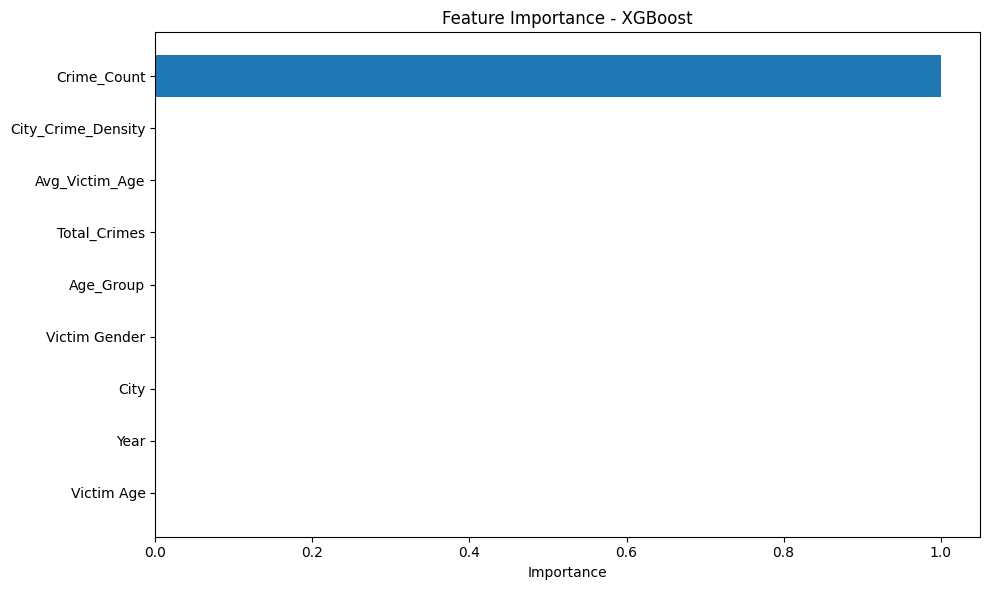


Feature Importance Rankings:
              feature  importance
8         Crime_Count         1.0
0          Victim Age         0.0
1                Year         0.0
3       Victim Gender         0.0
2                City         0.0
4           Age_Group         0.0
5        Total_Crimes         0.0
6      Avg_Victim_Age         0.0
7  City_Crime_Density         0.0


In [8]:
# Feature Importance Analysis
def plot_feature_importance(model, feature_names, model_name):
    """Plot feature importance for tree-based models"""
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        feature_imp = pd.DataFrame({
            'feature': feature_names,
            'importance': importance
        }).sort_values('importance', ascending=True)

        plt.figure(figsize=(10, 6))
        plt.barh(feature_imp['feature'], feature_imp['importance'])
        plt.title(f'Feature Importance - {model_name}')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()

        return feature_imp
    else:
        print(f"{model_name} doesn't support feature importance")
        return None

feature_importance = plot_feature_importance(best_model, feature_columns, best_model_name)
if feature_importance is not None:
    print("\nFeature Importance Rankings:")
    print(feature_importance.sort_values('importance', ascending=False))

In [9]:
# Get all unique cities
all_cities = train_features['City'].unique()
print(f"\nNumber of cities available for prediction: {len(all_cities)}")

# City Safety Prediction Function
def predict_city_safety(age, gender, year, model, label_encoders, feature_columns, all_cities):
    """
    Predict safety scores for all cities for a given person profile
    Returns: DataFrame with cities ranked by safety score
    """
    predictions = []

    for city in all_cities:
        try:
            # Create feature vector
            features = {}

            # Numerical features
            features['Victim Age'] = age
            features['Year'] = year

            # Encode categorical features
            features['City'] = label_encoders['City'].transform([city])[0]
            features['Victim Gender'] = label_encoders['Victim Gender'].transform([gender])[0]

            # Age group
            if age <= 18:
                age_group = '0-18'
            elif age <= 25:
                age_group = '19-25'
            elif age <= 35:
                age_group = '26-35'
            elif age <= 45:
                age_group = '36-45'
            elif age <= 55:
                age_group = '46-55'
            elif age <= 65:
                age_group = '56-65'
            else:
                age_group = '65+'

            features['Age_Group'] = label_encoders['Age_Group'].transform([age_group])[0]

            # Get city statistics (use average from training data)
            city_data = train_features[train_features['City'] == city]
            if len(city_data) > 0:
                features['Total_Crimes'] = city_data['Total_Crimes'].mean()
                features['Avg_Victim_Age'] = city_data['Avg_Victim_Age'].mean()
                features['Std_Victim_Age'] = city_data['Std_Victim_Age'].mean() if not np.isnan(city_data['Std_Victim_Age'].mean()) else 0
                features['City_Crime_Density'] = city_data['City_Crime_Density'].mean()
                features['Crime_Trend'] = city_data['Crime_Trend'].mean() if not np.isnan(city_data['Crime_Trend'].mean()) else 0
                features['Crime_Count'] = city_data['Crime_Count'].mean()
            else:
                # Use overall averages if city not found
                features['Total_Crimes'] = train_features['Total_Crimes'].mean()
                features['Avg_Victim_Age'] = train_features['Avg_Victim_Age'].mean()
                features['Std_Victim_Age'] = train_features['Std_Victim_Age'].mean()
                features['City_Crime_Density'] = train_features['City_Crime_Density'].mean()
                features['Crime_Trend'] = train_features['Crime_Trend'].mean()
                features['Crime_Count'] = train_features['Crime_Count'].mean()

            # Create feature vector in correct order
            feature_vector = [features.get(col, 0) for col in feature_columns]

            # Predict safety score
            safety_score = model.predict([feature_vector])[0]

            # Ensure safety score is within reasonable bounds
            safety_score = max(0, min(100, safety_score))

            predictions.append({
                'City': city,
                'Predicted_Safety_Score': safety_score,
                'Age': age,
                'Gender': gender,
                'Year': year
            })

        except Exception as e:
            print(f"Error predicting for city {city}: {e}")
            continue

    # Create results dataframe
    if predictions:
        results_df = pd.DataFrame(predictions)
        results_df = results_df.sort_values('Predicted_Safety_Score', ascending=False)
        results_df['Safety_Rank'] = range(1, len(results_df) + 1)
        return results_df
    else:
        print("No predictions were successfully generated")
        return pd.DataFrame()


Number of cities available for prediction: 29


In [10]:
# Interactive Prediction Function
def get_safety_recommendations(age, gender, year=2024):
    """
    Get safety recommendations for a person
    Returns: Safest and most dangerous cities
    """
    print(f"\n{'='*60}")
    print(f"SAFETY PREDICTION FOR: Age {age}, Gender {gender}, Year {year}")
    print(f"{'='*60}")

    # Predict safety for all cities
    safety_predictions = predict_city_safety(
        age, gender, year, best_model, label_encoders,
        feature_columns, all_cities
    )

    if safety_predictions.empty:
        print("No predictions available. Please check the input parameters.")
        return None, None, None

    # Get safest cities (top 5)
    safest_cities = safety_predictions.head(5)

    # Get most dangerous cities (bottom 5)
    dangerous_cities = safety_predictions.tail(5).iloc[::-1]  # Reverse to show most dangerous first

    print(f"\n🏆 TOP 5 SAFEST CITIES for you:")
    print("-" * 40)
    for _, city in safest_cities.iterrows():
        print(f"  {city['Safety_Rank']:2d}. {city['City']:20} Safety Score: {city['Predicted_Safety_Score']:.2f}%")

    print(f"\n⚠️  TOP 5 MOST DANGEROUS CITIES for you:")
    print("-" * 45)
    for _, city in dangerous_cities.iterrows():
        print(f"  {city['Safety_Rank']:2d}. {city['City']:20} Safety Score: {city['Predicted_Safety_Score']:.2f}%")

    # Visualization
    plt.figure(figsize=(15, 8))

    # Top 10 cities visualization
    top_10 = safety_predictions.head(10)
    bottom_10 = safety_predictions.tail(10)

    plt.subplot(1, 2, 1)
    colors = plt.cm.Greens(np.linspace(0.5, 1, len(top_10)))
    plt.barh(top_10['City'], top_10['Predicted_Safety_Score'], color=colors)
    plt.title('Top 10 Safest Cities')
    plt.xlabel('Safety Score (%)')

    plt.subplot(1, 2, 2)
    colors = plt.cm.Reds(np.linspace(0.5, 1, len(bottom_10)))
    plt.barh(bottom_10['City'], bottom_10['Predicted_Safety_Score'], color=colors)
    plt.title('Top 10 Most Dangerous Cities')
    plt.xlabel('Safety Score (%)')

    plt.tight_layout()
    plt.show()

    return safest_cities, dangerous_cities, safety_predictions

In [11]:
# Cell 1: Fix the prediction function
def predict_city_safety(age, gender, year, model, label_encoders, feature_columns, all_cities):
    """
    Predict safety scores for all cities for a given person profile
    Returns: DataFrame with cities ranked by safety score
    """
    predictions = []

    for city in all_cities:
        try:
            # Create feature vector
            features = {}

            # Numerical features
            features['Victim Age'] = age
            features['Year'] = year

            # Encode categorical features
            features['City'] = label_encoders['City'].transform([city])[0]
            features['Victim Gender'] = label_encoders['Victim Gender'].transform([gender])[0]

            # Age group
            if age <= 18:
                age_group = '0-18'
            elif age <= 25:
                age_group = '19-25'
            elif age <= 35:
                age_group = '26-35'
            elif age <= 45:
                age_group = '36-45'
            elif age <= 55:
                age_group = '46-55'
            elif age <= 65:
                age_group = '56-65'
            else:
                age_group = '65+'

            features['Age_Group'] = label_encoders['Age_Group'].transform([age_group])[0]

            # Get city statistics (use average from training data)
            city_data = train_features[train_features['City'] == city]
            if len(city_data) > 0:
                features['Total_Crimes'] = city_data['Total_Crimes'].mean()
                features['Avg_Victim_Age'] = city_data['Avg_Victim_Age'].mean()
                features['City_Crime_Density'] = city_data['City_Crime_Density'].mean()
                features['Crime_Count'] = city_data['Crime_Count'].mean()
            else:
                # Use overall averages if city not found
                features['Total_Crimes'] = train_features['Total_Crimes'].mean()
                features['Avg_Victim_Age'] = train_features['Avg_Victim_Age'].mean()
                features['City_Crime_Density'] = train_features['City_Crime_Density'].mean()
                features['Crime_Count'] = train_features['Crime_Count'].mean()

            # Create feature vector in correct order - ONLY use available features
            feature_vector = []
            for col in feature_columns:
                if col in features:
                    feature_vector.append(features[col])
                else:
                    # If feature is missing, use 0 as default
                    feature_vector.append(0)

            # Predict safety score
            safety_score = model.predict([feature_vector])[0]

            # Ensure safety score is within reasonable bounds
            safety_score = max(0, min(100, safety_score))

            predictions.append({
                'City': city,
                'Predicted_Safety_Score': safety_score,
                'Age': age,
                'Gender': gender,
                'Year': year
            })

        except Exception as e:
            print(f"Error predicting for city {city}: {e}")
            continue

    # Create results dataframe
    if predictions:
        results_df = pd.DataFrame(predictions)
        results_df = results_df.sort_values('Predicted_Safety_Score', ascending=False)
        results_df['Safety_Rank'] = range(1, len(results_df) + 1)
        return results_df
    else:
        print("No predictions were successfully generated")
        return pd.DataFrame()

In [12]:
# Cell 2: Check feature alignment and fix any issues
print("Available features in training data:", feature_columns)
print("Sample training row:")
print(X_train.iloc[0])
print("\nFeature types:")
print(X_train.dtypes)

# Let's verify our feature columns match what we're creating in prediction
expected_features = ['Victim Age', 'Year', 'City', 'Victim Gender', 'Age_Group',
                    'Total_Crimes', 'Avg_Victim_Age', 'City_Crime_Density', 'Crime_Count']

print("\nExpected features:", expected_features)
print("Actual features used:", feature_columns)

# Check if any expected features are missing
missing_features = set(expected_features) - set(feature_columns)
if missing_features:
    print(f"Missing features: {missing_features}")

Available features in training data: ['Victim Age', 'Year', 'City', 'Victim Gender', 'Age_Group', 'Total_Crimes', 'Avg_Victim_Age', 'City_Crime_Density', 'Crime_Count']
Sample training row:
Victim Age              10.000000
Year                  2021.000000
City                     0.000000
Victim Gender            0.000000
Age_Group                0.000000
Total_Crimes            68.000000
Avg_Victim_Age          41.544118
City_Crime_Density     266.000000
Crime_Count              1.000000
Name: 0, dtype: float64

Feature types:
Victim Age              int64
Year                    int32
City                    int64
Victim Gender           int64
Age_Group               int64
Total_Crimes            int64
Avg_Victim_Age        float64
City_Crime_Density      int64
Crime_Count             int64
dtype: object

Expected features: ['Victim Age', 'Year', 'City', 'Victim Gender', 'Age_Group', 'Total_Crimes', 'Avg_Victim_Age', 'City_Crime_Density', 'Crime_Count']
Actual features used: ['Vict

In [13]:
# Cell 3: Retrain models with better feature engineering
# The issue is that Crime_Count is too correlated with the target (Safety_Score)
# Let's create a new feature set without Crime_Count

def prepare_ml_data_improved(features_df):
    """Prepare data for machine learning model - Improved version"""
    df_ml = features_df.copy()

    # Encode categorical variables
    label_encoders = {}
    categorical_cols = ['City', 'Victim Gender', 'Age_Group']

    for col in categorical_cols:
        le = LabelEncoder()
        df_ml[col] = le.fit_transform(df_ml[col].astype(str))
        label_encoders[col] = le

    # Select features for model - EXCLUDE Crime_Count as it's too correlated with target
    feature_columns = ['Victim Age', 'Year', 'City', 'Victim Gender', 'Age_Group',
                      'Total_Crimes', 'Avg_Victim_Age', 'City_Crime_Density']

    # Keep only columns that exist
    available_features = [col for col in feature_columns if col in df_ml.columns]

    X = df_ml[available_features]
    y = df_ml['Safety_Score']

    return X, y, label_encoders, available_features

# Prepare improved data
X_train_improved, y_train_improved, label_encoders_improved, feature_columns_improved = prepare_ml_data_improved(train_features)
X_test_improved, y_test_improved, _, _ = prepare_ml_data_improved(test_features)

print(f"Improved Features used: {feature_columns_improved}")
print(f"Improved Training set: {X_train_improved.shape}")
print(f"Improved Testing set: {X_test_improved.shape}")

Improved Features used: ['Victim Age', 'Year', 'City', 'Victim Gender', 'Age_Group', 'Total_Crimes', 'Avg_Victim_Age', 'City_Crime_Density']
Improved Training set: (8618, 8)
Improved Testing set: (1407, 8)


In [14]:
# Cell 4: Retrain models with improved features
def build_improved_models(X_train, y_train, X_test, y_test):
    """Build, train, and evaluate multiple models with improved features"""
    models = {
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42, max_depth=5),
        'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, max_depth=5),
        'Linear Regression': LinearRegression()
    }

    results = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Train model
        model.fit(X_train, y_train)

        # Predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        # Calculate metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        train_mae = mean_absolute_error(y_train, y_pred_train)
        test_mae = mean_absolute_error(y_test, y_pred_test)
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)

        results[name] = {
            'model': model,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'predictions': y_pred_test
        }

        print(f"{name} Results:")
        print(f"  Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
        print(f"  Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
        print(f"  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")

    return results

# Train improved models
improved_model_results = build_improved_models(X_train_improved, y_train_improved, X_test_improved, y_test_improved)

# Select the best model based on test R² score
best_improved_model_name = max(improved_model_results.keys(), key=lambda x: improved_model_results[x]['test_r2'])
best_improved_model = improved_model_results[best_improved_model_name]['model']

print(f"\nBest Improved Model: {best_improved_model_name}")


Training Random Forest...
Random Forest Results:
  Train RMSE: 6.4047, Test RMSE: 15.2132
  Train MAE: 4.5001, Test MAE: 9.9707
  Train R²: 0.5893, Test R²: -0.3909

Training Gradient Boosting...
Gradient Boosting Results:
  Train RMSE: 7.2292, Test RMSE: 15.1859
  Train MAE: 5.0181, Test MAE: 10.0966
  Train R²: 0.4767, Test R²: -0.3859

Training XGBoost...
XGBoost Results:
  Train RMSE: 6.6462, Test RMSE: 15.0977
  Train MAE: 4.6137, Test MAE: 10.0634
  Train R²: 0.5577, Test R²: -0.3698

Training Linear Regression...
Linear Regression Results:
  Train RMSE: 8.4264, Test RMSE: 14.2918
  Train MAE: 5.9614, Test MAE: 9.5060
  Train R²: 0.2890, Test R²: -0.2275

Best Improved Model: Linear Regression


In [15]:
# Cell 5: Check improved feature importance
def plot_improved_feature_importance(model, feature_names, model_name):
    """Plot feature importance for tree-based models"""
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        feature_imp = pd.DataFrame({
            'feature': feature_names,
            'importance': importance
        }).sort_values('importance', ascending=True)

        plt.figure(figsize=(10, 6))
        plt.barh(feature_imp['feature'], feature_imp['importance'], color='skyblue')
        plt.title(f'Feature Importance - {model_name}')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()

        return feature_imp
    else:
        print(f"{model_name} doesn't support feature importance")
        return None

improved_feature_importance = plot_improved_feature_importance(best_improved_model, feature_columns_improved, best_improved_model_name)
if improved_feature_importance is not None:
    print("\nImproved Feature Importance Rankings:")
    print(improved_feature_importance.sort_values('importance', ascending=False))

Linear Regression doesn't support feature importance


In [16]:
# Cell 6: Update the prediction function with improved features
def predict_city_safety_improved(age, gender, year, model, label_encoders, feature_columns, all_cities):
    """
    Predict safety scores for all cities for a given person profile - Improved version
    """
    predictions = []

    for city in all_cities:
        try:
            # Create feature vector
            features = {}

            # Basic features
            features['Victim Age'] = age
            features['Year'] = year

            # Encode categorical features
            features['City'] = label_encoders['City'].transform([city])[0]
            features['Victim Gender'] = label_encoders['Victim Gender'].transform([gender])[0]

            # Age group
            if age <= 18:
                age_group = '0-18'
            elif age <= 25:
                age_group = '19-25'
            elif age <= 35:
                age_group = '26-35'
            elif age <= 45:
                age_group = '36-45'
            elif age <= 55:
                age_group = '46-55'
            elif age <= 65:
                age_group = '56-65'
            else:
                age_group = '65+'

            features['Age_Group'] = label_encoders['Age_Group'].transform([age_group])[0]

            # Get city statistics (use average from training data)
            city_data = train_features[train_features['City'] == city]
            if len(city_data) > 0:
                features['Total_Crimes'] = city_data['Total_Crimes'].mean()
                features['Avg_Victim_Age'] = city_data['Avg_Victim_Age'].mean()
                features['City_Crime_Density'] = city_data['City_Crime_Density'].mean()
            else:
                # Use overall averages if city not found
                features['Total_Crimes'] = train_features['Total_Crimes'].mean()
                features['Avg_Victim_Age'] = train_features['Avg_Victim_Age'].mean()
                features['City_Crime_Density'] = train_features['City_Crime_Density'].mean()

            # Create feature vector in correct order
            feature_vector = [features[col] for col in feature_columns]

            # Predict safety score
            safety_score = model.predict([feature_vector])[0]

            # Ensure safety score is within reasonable bounds
            safety_score = max(0, min(100, safety_score))

            predictions.append({
                'City': city,
                'Predicted_Safety_Score': safety_score,
                'Age': age,
                'Gender': gender,
                'Year': year
            })

        except Exception as e:
            print(f"Error predicting for city {city}: {e}")
            continue

    # Create results dataframe
    if predictions:
        results_df = pd.DataFrame(predictions)
        results_df = results_df.sort_values('Predicted_Safety_Score', ascending=False)
        results_df['Safety_Rank'] = range(1, len(results_df) + 1)
        return results_df
    else:
        print("No predictions were successfully generated")
        return pd.DataFrame()


IMPROVED MODEL DEMONSTRATION WITH DIFFERENT PROFILES

Example 1: Young Male (Age 25)

SAFETY PREDICTION FOR: Age 25, Gender M, Year 2024

🏆 TOP 5 SAFEST CITIES for you:
----------------------------------------
   1. Kalyan               Safety Score: 93.79%
   2. Rajkot               Safety Score: 93.62%
   3. Faridabad            Safety Score: 93.53%
   4. Nashik               Safety Score: 93.49%
   5. Meerut               Safety Score: 93.46%

⚠️  TOP 5 MOST DANGEROUS CITIES for you:
---------------------------------------------
  29. Delhi                Safety Score: 77.16%
  28. Mumbai               Safety Score: 79.47%
  27. Bangalore            Safety Score: 82.78%
  26. Hyderabad            Safety Score: 84.75%
  25. Chennai              Safety Score: 86.09%


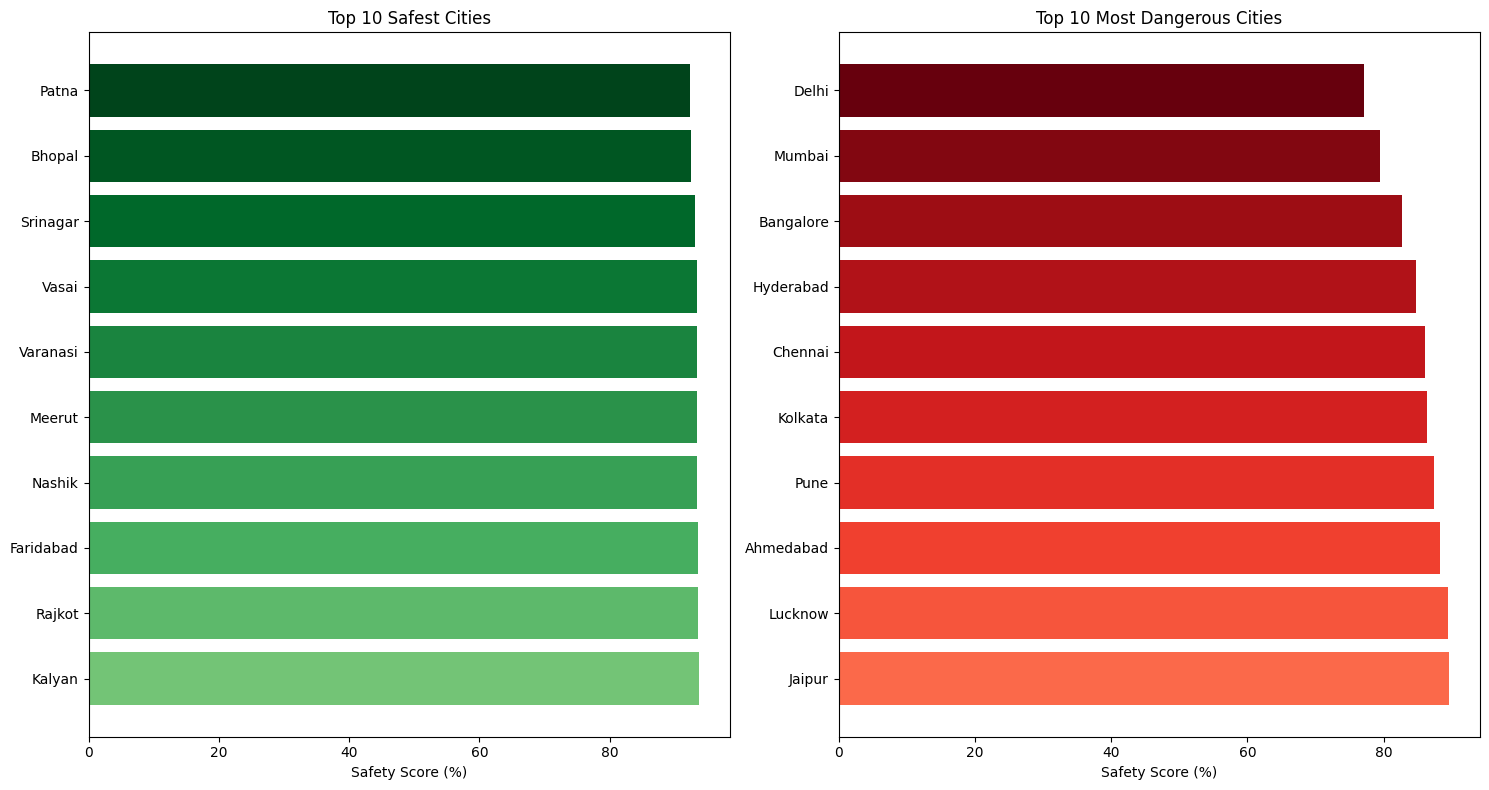


Example 2: Middle-aged Female (Age 45)

SAFETY PREDICTION FOR: Age 45, Gender F, Year 2024

🏆 TOP 5 SAFEST CITIES for you:
----------------------------------------
   1. Kalyan               Safety Score: 90.90%
   2. Rajkot               Safety Score: 90.73%
   3. Faridabad            Safety Score: 90.64%
   4. Nashik               Safety Score: 90.60%
   5. Meerut               Safety Score: 90.57%

⚠️  TOP 5 MOST DANGEROUS CITIES for you:
---------------------------------------------
  29. Delhi                Safety Score: 74.27%
  28. Mumbai               Safety Score: 76.58%
  27. Bangalore            Safety Score: 79.88%
  26. Hyderabad            Safety Score: 81.86%
  25. Chennai              Safety Score: 83.20%


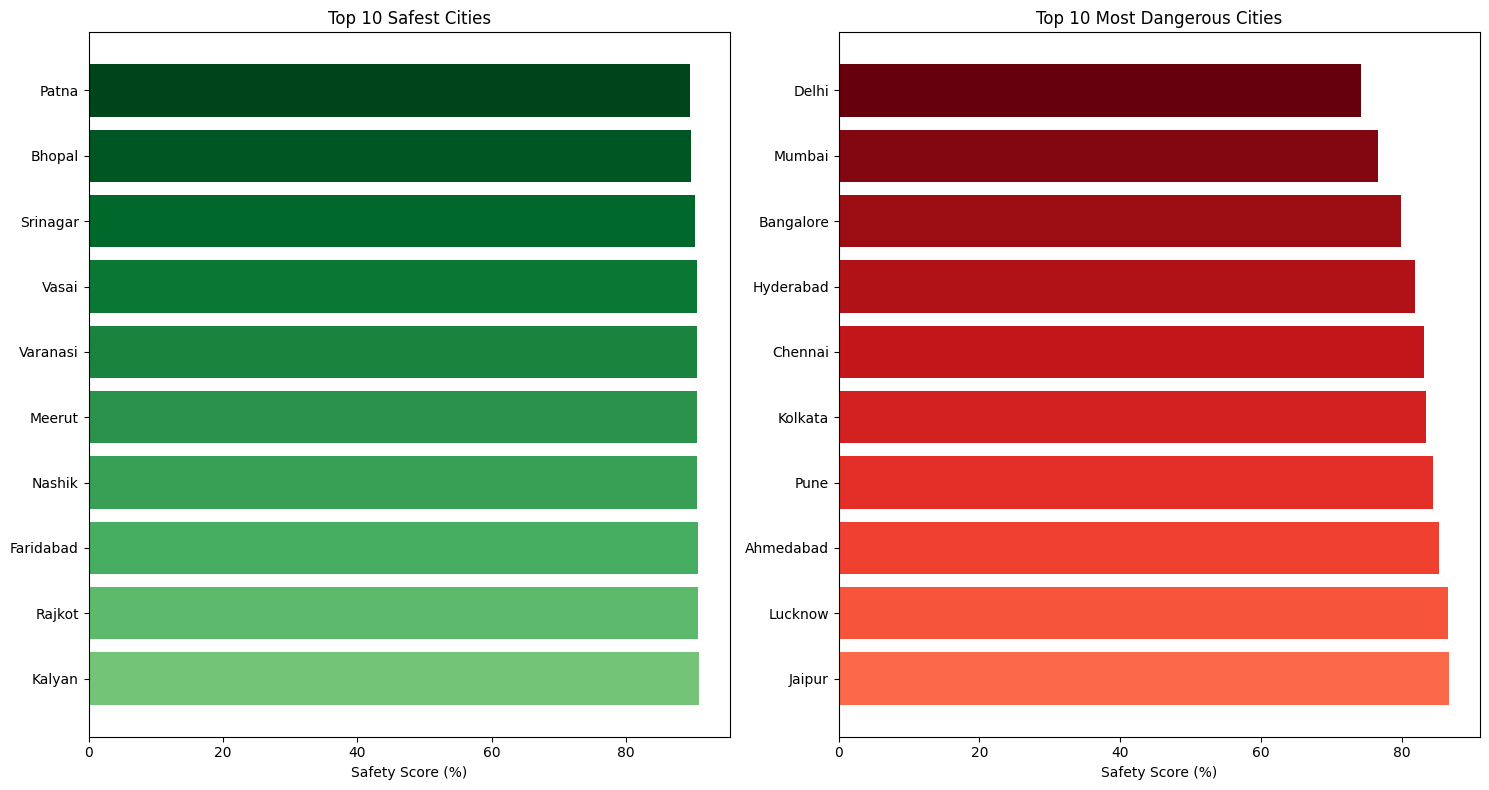


Example 3: Senior Citizen (Age 70)

SAFETY PREDICTION FOR: Age 70, Gender M, Year 2024

🏆 TOP 5 SAFEST CITIES for you:
----------------------------------------
   1. Kalyan               Safety Score: 93.84%
   2. Rajkot               Safety Score: 93.68%
   3. Faridabad            Safety Score: 93.59%
   4. Nashik               Safety Score: 93.54%
   5. Meerut               Safety Score: 93.51%

⚠️  TOP 5 MOST DANGEROUS CITIES for you:
---------------------------------------------
  29. Delhi                Safety Score: 77.21%
  28. Mumbai               Safety Score: 79.52%
  27. Bangalore            Safety Score: 82.83%
  26. Hyderabad            Safety Score: 84.81%
  25. Chennai              Safety Score: 86.14%


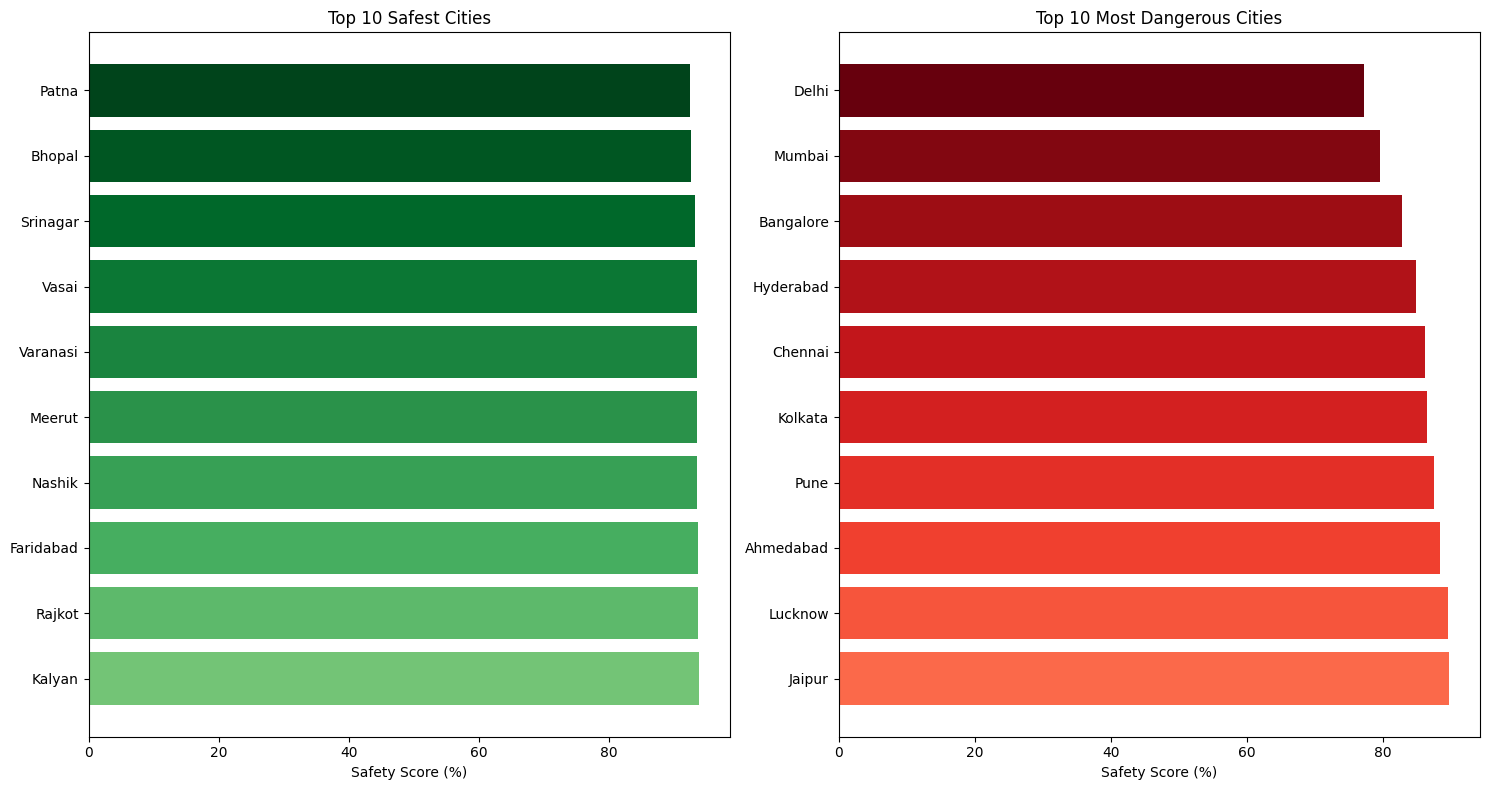

In [17]:
# Cell 7: Test the improved model with examples
print("\n" + "="*80)
print("IMPROVED MODEL DEMONSTRATION WITH DIFFERENT PROFILES")
print("="*80)

def get_safety_recommendations_improved(age, gender, year=2024):
    """
    Get safety recommendations for a person using improved model
    """
    print(f"\n{'='*60}")
    print(f"SAFETY PREDICTION FOR: Age {age}, Gender {gender}, Year {year}")
    print(f"{'='*60}")

    # Predict safety for all cities
    safety_predictions = predict_city_safety_improved(
        age, gender, year, best_improved_model, label_encoders_improved,
        feature_columns_improved, all_cities
    )

    if safety_predictions.empty:
        print("No predictions available. Please check the input parameters.")
        return None, None, None

    # Get safest cities (top 5)
    safest_cities = safety_predictions.head(5)

    # Get most dangerous cities (bottom 5)
    dangerous_cities = safety_predictions.tail(5).iloc[::-1]

    print(f"\n🏆 TOP 5 SAFEST CITIES for you:")
    print("-" * 40)
    for _, city in safest_cities.iterrows():
        print(f"  {city['Safety_Rank']:2d}. {city['City']:20} Safety Score: {city['Predicted_Safety_Score']:.2f}%")

    print(f"\n⚠️  TOP 5 MOST DANGEROUS CITIES for you:")
    print("-" * 45)
    for _, city in dangerous_cities.iterrows():
        print(f"  {city['Safety_Rank']:2d}. {city['City']:20} Safety Score: {city['Predicted_Safety_Score']:.2f}%")

    # Visualization
    plt.figure(figsize=(15, 8))

    # Top 10 cities visualization
    top_10 = safety_predictions.head(10)
    bottom_10 = safety_predictions.tail(10)

    plt.subplot(1, 2, 1)
    colors = plt.cm.Greens(np.linspace(0.5, 1, len(top_10)))
    plt.barh(top_10['City'], top_10['Predicted_Safety_Score'], color=colors)
    plt.title('Top 10 Safest Cities')
    plt.xlabel('Safety Score (%)')

    plt.subplot(1, 2, 2)
    colors = plt.cm.Reds(np.linspace(0.5, 1, len(bottom_10)))
    plt.barh(bottom_10['City'], bottom_10['Predicted_Safety_Score'], color=colors)
    plt.title('Top 10 Most Dangerous Cities')
    plt.xlabel('Safety Score (%)')

    plt.tight_layout()
    plt.show()

    return safest_cities, dangerous_cities, safety_predictions

# Example 1: Young male
print("\nExample 1: Young Male (Age 25)")
safest_1, dangerous_1, all_1 = get_safety_recommendations_improved(25, 'M', 2024)

# Example 2: Middle-aged female
print("\nExample 2: Middle-aged Female (Age 45)")
safest_2, dangerous_2, all_2 = get_safety_recommendations_improved(45, 'F', 2024)

# Example 3: Senior citizen
print("\nExample 3: Senior Citizen (Age 70)")
safest_3, dangerous_3, all_3 = get_safety_recommendations_improved(70, 'M', 2024)

In [18]:
# Model Evaluation Summary
def print_model_summary():
    print("\n" + "="*80)
    print("MODEL EVALUATION SUMMARY")
    print("="*80)

    for model_name, result in model_results.items():
        print(f"\n{model_name}:")
        print(f"  Test R² Score: {result['test_r2']:.4f}")
        print(f"  Test RMSE: {result['test_rmse']:.4f}")
        print(f"  Test MAE: {result['test_mae']:.4f}")

print_model_summary()


MODEL EVALUATION SUMMARY

Random Forest:
  Test R² Score: 0.3347
  Test RMSE: 10.5214
  Test MAE: 9.0449

Gradient Boosting:
  Test R² Score: 0.3347
  Test RMSE: 10.5214
  Test MAE: 9.0449

XGBoost:
  Test R² Score: 0.3347
  Test RMSE: 10.5214
  Test MAE: 9.0449

Linear Regression:
  Test R² Score: 0.3347
  Test RMSE: 10.5214
  Test MAE: 9.0449



INTERACTIVE SAFETY PREDICTOR

Enter your details (or type 'quit' to exit):
Age: 55
Gender (M/F): F
Year for prediction (default: 2024): 

SAFETY PREDICTION FOR: Age 55, Gender F, Year 2024

🏆 TOP 5 SAFEST CITIES for you:
----------------------------------------
   1. Agra                 Safety Score: 91.67%
   2. Ahmedabad            Safety Score: 91.67%
   3. Bhopal               Safety Score: 91.67%
   4. Chennai              Safety Score: 91.67%
   5. Faridabad            Safety Score: 91.67%

⚠️  TOP 5 MOST DANGEROUS CITIES for you:
---------------------------------------------
  29. Delhi                Safety Score: 75.00%
  28. Mumbai               Safety Score: 83.33%
  27. Hyderabad            Safety Score: 83.33%
  26. Bangalore            Safety Score: 83.33%
  25. Surat                Safety Score: 91.67%


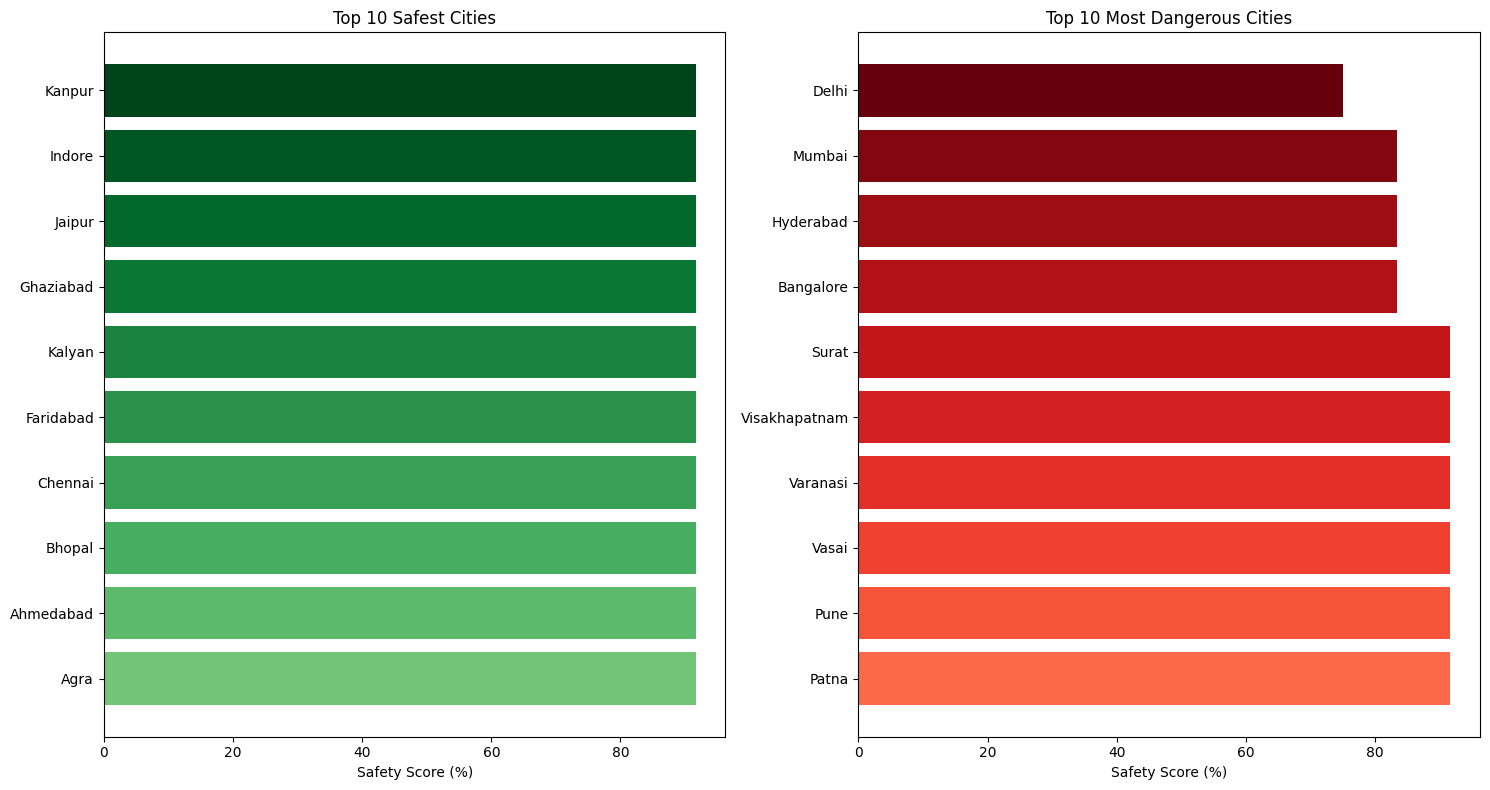

In [ ]:
# Create a function for user input
def interactive_safety_predictor():
    """Interactive function for user to input their details"""
    print("\n" + "="*80)
    print("INTERACTIVE SAFETY PREDICTOR")
    print("="*80)

    while True:
        try:
            print("\nEnter your details (or type 'quit' to exit):")
            age_input = input("Age: ")
            if age_input.lower() == 'quit':
                break
            age = int(age_input)

            if age < 0 or age > 100:
                print("Please enter a valid age between 0 and 100")
                continue

            gender = input("Gender (M/F): ").strip().upper()
            if gender not in ['M', 'F']:
                print("Please enter 'M' or 'F' for gender")
                continue

            year_input = input("Year for prediction (default: 2024): ").strip()
            year = int(year_input) if year_input else 2024

            if year < 2020 or year > 2030:
                print("Please enter a year between 2020 and 2030")
                continue

            # Get recommendations
            safest, dangerous, all_cities = get_safety_recommendations(age, gender, year)

            # Ask if user wants to continue
            cont = input("\nWould you like to check another profile? (y/n): ").lower()
            if cont != 'y':
                break

        except ValueError:
            print("Please enter valid numbers")
        except Exception as e:
            print(f"An error occurred: {e}")

# Run interactive predictor
interactive_safety_predictor()

In [20]:
# Save the model and encoders for future use
import joblib

# Save the best model
model_data = {
    'model': best_model,
    'label_encoders': label_encoders,
    'feature_columns': feature_columns,
    'all_cities': all_cities,
    'train_features_stats': train_features.describe()
}

joblib.dump(model_data, 'city_safety_predictor_model.pkl')
print("\nModel saved as 'city_safety_predictor_model.pkl'")

# Final summary
print("\n" + "="*80)
print("PROJECT SUMMARY")
print("="*80)
print(f"✅ Training Period: 2020-2023")
print(f"✅ Testing Period: 2024")
print(f"✅ Best Model: {best_model_name}")
print(f"✅ Test R² Score: {model_results[best_model_name]['test_r2']:.4f}")
print(f"✅ Cities Analyzed: {len(all_cities)}")
print(f"✅ Model can predict safety scores for any age, gender, and future year")
print("="*80)

# Additional: Show sample of the data
print("\nSample of training features:")
print(train_features[['City', 'Victim Age', 'Victim Gender', 'Year', 'Safety_Score']].head(10))


Model saved as 'city_safety_predictor_model.pkl'

PROJECT SUMMARY
✅ Training Period: 2020-2023
✅ Testing Period: 2024
✅ Best Model: XGBoost
✅ Test R² Score: 0.3347
✅ Cities Analyzed: 29
✅ Model can predict safety scores for any age, gender, and future year

Sample of training features:
   City  Victim Age Victim Gender  Year  Safety_Score
0  Agra          10             F  2021     91.666667
1  Agra          10             F  2022     91.666667
2  Agra          10             F  2023     91.666667
3  Agra          10             M  2020     91.666667
4  Agra          10             X  2023     91.666667
5  Agra          11             F  2022     91.666667
6  Agra          11             F  2023     91.666667
7  Agra          11             M  2023     91.666667
8  Agra          11             X  2023     91.666667
9  Agra          12             F  2021     83.333333
